## Lookback put option (floating strike) validation


For validation purposes, we compared the results from our implementation of the floating strike look-back put option with the convergence and performance values provided in Broadie, Glasserman, and Kou (1999). 

"Broadie, M., Glasserman, P., & Kou, S.G. (1999). Connecting discrete and continuous path-dependent options. Finance and Stochastics, 3(1), 55-82. doi:10.1007/s007800050054"

In [1]:
from datetime import datetime

import numpy as np
from finmc.models.localvol import LVMC
from qablet.base.mc import MCPricer
from qablet_contracts.timetable import py_to_ts

from src.contracts.lookback import lookback_put_timetable

In [2]:
MC_PARAMS = {
    "PATHS": 100_000,
    "TIMESTEP": 1 / 250,
    "SEED": 1,
}


# Provided data functions
def basic_info():
    return {
        "prc_dt": datetime(2005, 9, 14),
        "ticker": "SPX",
        "ccy": "USD",
        "spot": 100,  # Using spot price as 100
    }


def assets_data(rate=0.1):
    info = basic_info()

    div_rate = 0
    times = np.array([0.0, 5.0])
    rates = np.array([rate, rate])
    discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

    fwds = info["spot"] * np.exp((rates - div_rate) * times)
    fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

    return {info["ccy"]: discount_data, info["ticker"]: fwd_data}


def localvol_data(rate=0.1):
    info = basic_info()

    return {
        "BASE": "USD",
        "PRICING_TS": py_to_ts(info["prc_dt"]).value,
        "ASSETS": assets_data(rate=rate),
        "MC": MC_PARAMS,
        "LV": {"ASSET": "SPX", "VOL": 0.3},
    }

In [3]:
# Validation of Local Vol for parameters S0=100, r=0.1, T=0.2 Yrs, m=4
ticker = "SPX"
start_date = "2005-09-14"
T = 0.2
num_points = 4

# Creating a look-back put option timetable
timetable = lookback_put_timetable(ticker, start_date, T, num_points)

# Pricing with Local Volatility Model
localvol_dataset = localvol_data(rate=0.1)
localvol_model = MCPricer(LVMC)
price, _ = localvol_model.price(timetable, localvol_dataset)
print(f"LocalVol put price for Table 2 parameters: {price}\n")

# Validation of Local Vol for parameters S0=100, r=0.1, T=0.5yrs with varying m
m_values = [5, 10, 20, 40, 80, 160]
T = 0.5
print("LocalVol put price for Table  3 parameters:")
for m in m_values:
    timetable = lookback_put_timetable(ticker, start_date, T, m)

    # Pricing with Local Volatility Model
    price, _ = localvol_model.price(timetable, localvol_dataset)
    print(f"m={m}: {price}")

LocalVol put price for Table 2 parameters: 6.6002598915196735

LocalVol put price for Table  3 parameters:
m=5: 10.09743149262846
m=10: 11.430019049618798
m=20: 12.465063477227147
m=40: 13.269032935798364
m=80: 13.864394800954551
m=160: 14.29718643156962


From "Broadie, M., Glasserman, P., & Kou, S.G. (1999). Connecting discrete and continuous path-dependent options. Finance and Stochastics, 3(1), 55-82. doi:10.1007/s007800050054"

Refer to Table 3. Standard Values(True Prices) of a discrete lookback put option given the parameters, S0 = 100, r = 0.1, σ = 0.3, T = 0.5, with the number of monitoring points m [5,10,20,40,80,160]

In [4]:
# Standard table values for Table 3
standard_values_table3 = {
    5: 10.06425,
    10: 11.39775,
    20: 12.44463,
    40: 13.23942,
    80: 13.82950,
    160: 14.26104,
}


# Function to get local vol model values
def get_local_vol_values(m_values):
    local_vol_values = {}
    for m in m_values:
        timetable = lookback_put_timetable(ticker, start_date, T, m)
        price, _ = localvol_model.price(timetable, localvol_dataset)
        local_vol_values[m] = price
    return local_vol_values


# Table 3 parameters with varying m
m_values = [
    5,
    10,
    20,
    40,
    80,
    160,
]  # Different monitoring points as per Table 3

# Calculating local vol model values dynamically
local_vol_values_table3 = get_local_vol_values(m_values)

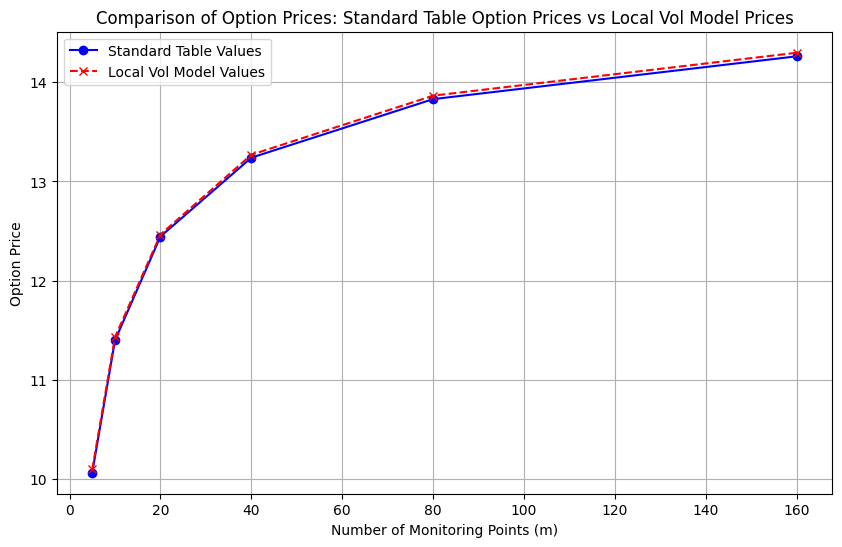

In [5]:
import matplotlib.pyplot as plt

# Plotting the comparison for Table 3
plt.figure(figsize=(10, 6))

# Plotting standard table values
plt.plot(
    standard_values_table3.keys(),
    standard_values_table3.values(),
    marker="o",
    linestyle="-",
    color="b",
    label="Standard Table Values",
)

# Plotting local vol model values
plt.plot(
    local_vol_values_table3.keys(),
    local_vol_values_table3.values(),
    marker="x",
    linestyle="--",
    color="r",
    label="Local Vol Model Values",
)

plt.xlabel("Number of Monitoring Points (m)")
plt.ylabel("Option Price")
plt.title(
    "Comparison of Option Prices: Standard Table Option Prices vs Local Vol Model Prices"
)
plt.legend()
plt.grid(True)
plt.show()